# COGS 108 - Final Project 

# Overview

This project was an attempt to figure out if neighboring restaurants have any association with whether or not there were any critical violations upon health inspections. To do this, a predictive analysis using logistic regression was performed to categorize inputs. The results indicate that the relationship between these two variables is unclear, and that trying to predict with logistic regression is likely to be inaccurate. 

# Name & PID

- Name: Francis Dinh
- PID: A13019062

# Research Question

Is a restaurant more likely to have health code violations if its neighbors also have more health code violations (and vice versa)? 

## Background and Prior Work

References (include links):
- 1) http://cs229.stanford.edu/proj2013/Walter-PredictionOfNYCRestaurantHealthInspectionResults%20pdf.pdf
This publication outlines attempts at predicting grades that would be given to restaurants in the New York City. Since there are many restaurants with a high turnover rate relative to the number of inspectors, this means that many restaurants cannot be "graded" in a timely manner. Various classifiers such as Bayes Naive classifier or Logistic Regression were trained using other various features such as restaurant names, location, food type, etc. The paper concludes that machine learning techniques (useful for prediction) were able to predict to about 62% accuracy based just on restaurant zip code and food type. However, the paper also discusses potential pitfalls, such as some specific features (like restaurants with type: "Asian") resulting in almost random guesses. 

- 2) https://www.citylab.com/solutions/2016/01/chicago-is-predicting-food-safety-violations-why-arent-other-cities/422511/
The city of Chicago has actually implemented a similar idea, although specific methodologies are not mentioned. Using features such as length of time since last inspection, previous violations, nearby sanitation complaints, etc, an algorithm was developed that found violations 7.5 days earlier on average. The article does not list how this number was obtained however. One notable aspect of Chicago's project was that it attempted to open-source its work, which allowed Washington D.C. to try a similar approach, finding violations 3 days earlier on average. 

# Hypothesis


Restaurants that are closer to other restaurants that have had health code violations will have a greater chance of having health code violations of their own. The reason for having this belief encompasses factors such as location and similar suppliers. Restaurants that are neighbors may copy each others' behaviors or they may have similar problems affecting each other (rats do not stay in one place for example). 

# Dataset(s)

- Inspections Dataset
- Provided on Canvas (data.zip)
- 18466 Observations

The inspections dataset provides information about the restaurants, information about the inspectors, as well as results of inspections. 

# Setup

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Data Cleaning

We first read in the inspection dataset that we will be using. 

In [69]:
inspections = pd.read_csv('data/inspections.csv')
inspections = inspections[['avg_neighbor_num_critical', 'avg_neighbor_num_non_critical', 'critical']]

We will be dropping rows where there is no report for average neighbor's score (NaN) since that is the metric we are interested in. 

In [70]:
inspections = inspections.dropna()

The 'critical' column does not seem to need any additional cleaning as there are only values of '0' or '1', which for the sake of this project are 'false' and 'true' respectively. That is, if a restaurant does not have a critical health code violation, it receives a 0, and if it does, it receives a 1. 

In [72]:
inspections['critical'].unique()

array([1, 0])

# Data Analysis & Results

The 'critical' variable is critically important to this analysis, so we want to get an idea of how the data is distributed on it.

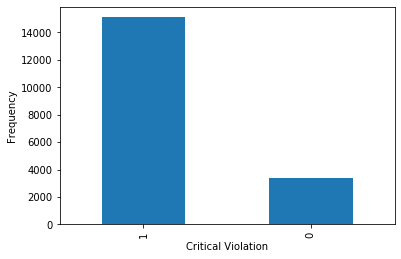

In [73]:
f = inspections['critical'].value_counts().plot(kind='bar')
f.set_xlabel('Critical Violation')
f.set_ylabel('Frequency')
plt.show()

It is apparent that the majority of inspections result in a critical violation, and we can take a quick look at this.

In [74]:
inspections['critical'].describe()

count    18460.000000
mean         0.818093
std          0.385778
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: critical, dtype: float64

We can indeed see that about 80% of inspections find a critical violation on average. 

Now if we examine the relationship between critical violations and average neighbor number of critical violations, we can see that there is an positive association (but not necessarily any causative one) between the two variables.

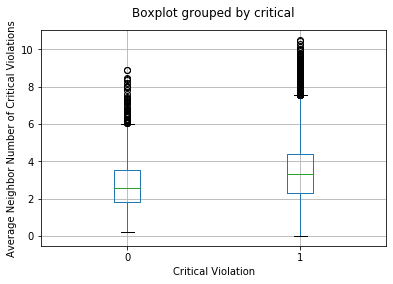

In [75]:
f = inspections.boxplot(column=['avg_neighbor_num_critical'], by='critical')
f.set_xlabel('Critical Violation')
f.set_ylabel('Average Neighbor Number of Critical Violations')
f.set_title('')
plt.show()

There are evidently some outliers that we might want to remove in order to better attempt to fit the data. However, removing outliers from critical violations grouped by 0 or 1 is not quite accurate because on prediction, we do not know ahead of time if an observation is part of group 0 or 1, so if we do remove outliers, we must do so on the "avg_neighbor_num_critical" variable as a whole. First, we check to see that the data follows at least to some extent, a normal distribution.

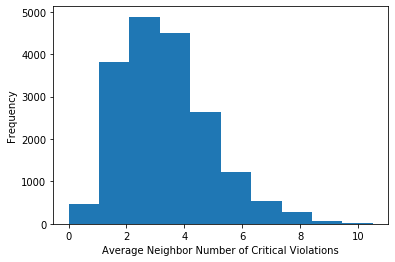

In [76]:
f = inspections['avg_neighbor_num_critical'].plot(kind='hist')
f.set_xlabel("Average Neighbor Number of Critical Violations")
plt.show()

We can see that the data does indeed actually fall along a normal distribution fairly well, but it does skew somewhat to the right, as we had seen in the previous box plot, where outliers were above the 75% quartile. However, it is important to consider whether we can actually remove outliers, since they may actually be indicative of further study required as opposed to just erroneous measurements. In this case, I have decided not to remove outliers for the following reasons:
1) There is currently no evidence that the outliers are erroneous observations
2) The skew itself could potentially be subject to further study (ex: At what point does using neighbors as a measurement become more or less effective?)

First, we consider the association between the average number of neighbors' critical violations on both the score given for an inspection and whether or not there was a critical violation. One approach is to perform logistic regression to create a categorical classifier with two possible outputs: critical violation or no critical violation.

In [77]:
x = inspections['avg_neighbor_num_critical']
y = inspections['critical']
trainSize = int(0.8 * len(x))
testSize = len(x) - trainSize;
x_train = x[:trainSize].values.reshape((trainSize, 1))
y_train = y[:trainSize]
x_test = x[trainSize:].values.reshape((testSize, 1))
y_test = y[trainSize:]

In [78]:
logmodel = LogisticRegression()
logmodel.fit(x_train, y_train)
predictions = logmodel.predict(x_test).reshape((testSize, 1))
logmodel.score(predictions, y_test)

0.766522210184182

We can see that the logistic regression model gets a prediction accuracy of about 76%. However, we have to be careful, since from prior analysis of the data, we need to remember that the dataset has a strong skew towards critical violations (about 80% mean). If a classifier were to always output 1, regardless of input, it would still get a fairly decent accuracy. The approach below is an attempt to balance this factor and see how the logistic classifier performs then.

In [79]:
logmodel = LogisticRegression(class_weight='balanced')
logmodel.fit(x_train, y_train)
predictions = logmodel.predict(x_test).reshape((testSize, 1))
logmodel.score(predictions, y_test)

0.233477789815818

It is apparent then that logistic regression on this balanced model does not perform well at all, with 23.6% accuracy. Randomly guessing should give around a 50% accuracy, which is better! We can try the same approach on the other neighbor metric, which is avg_neighbor_num_non_critical

In [80]:
x = inspections['avg_neighbor_num_non_critical']
y = inspections['critical']
trainSize = int(0.8 * len(x))
testSize = len(x) - trainSize;
x_train = x[:trainSize].values.reshape((trainSize, 1))
y_train = y[:trainSize]
x_test = x[trainSize:].values.reshape((testSize, 1))
y_test = y[trainSize:]
logmodel = LogisticRegression(class_weight="balanced")
logmodel.fit(x_train, y_train)
predictions = logmodel.predict(x_test).reshape((testSize, 1))
logmodel.score(predictions, y_test)

0.233477789815818

This seems to actually give basically identical results, and it may suggest that we cannot really predict using logistic regression, on neighbor metrics for critical violations. 

# Ethics & Privacy

A potential issue with developing a health inspection algorithm based on data is that certain restaurants may become unintentionally targeted. An example is if more restaurants in a certain area are sampled than restaurants in a different area, resulting in an overrepresentation in the data set. Features such as previous health code violations may also result in certain businesses being inspected more often even if it does not mean that other restaurants do not have violations (just that they have not been recorded/detected). Care should also be taken to ensure that restaurants are not specifically linked with data such as number of visitors and sales amounts (provided there is no permission). 

Care must be taken to ensure that both restaurants and inspectors are not adversely affected by the study. For example, inspector names have been included in the used dataset, and although not used in this observation, the information could be used to target individual inspectors. A separate survey, outside of the scope of this project, would be required to determine if individual inspectors are being fair/unfair in restaurant evaluations. Individual restaurant names were also included in the dataset, which also poses a similar problem, in that the data may be unfairly framed to target individual restaurants. Specifically in this survey, if data instead shows that neighbors do affect critical violations scores, restaurants may experience unfair loss of revenue for simply being near a certain neighbor. 

The data itself may also need to be independently studied to determine if it is "clean". For example, it shows that a large majority of inspections end up with critical violations, and the validity of that may need to be confirmed. For example, if restaurants in certain locations are being inspected more often, this may affect the validity of the dataset. 

# Conclusion & Discussion

Although not quite an ideal answer, it is unclear if neighbors are associated with restaurants being more likely to receive critical health code violations. Although a preliminary look at the data suggests that there is some association between the two variables (as seen in the box plot), this alone is insufficient evidence. The attempt to use a logistic classifier to predict likelihood of critical violation does seem to support that there is insufficient evidence as it does not predict very well. Of course, logistic classifiers are not the only sort of classifier, and there are probably better methods, and so further study is required before a definitive answer can be made. 